In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import timm

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LeavesDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, path="../data/A1"):
        self.path = path
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = [x for x in os.listdir(path) if x.endswith("_rgb.png")]
        self.masks = [x for x in os.listdir(path) if x.endswith("_label.png")]
        self.cnt = 0

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.path + "/" + self.imgs[idx]
        mask_path = self.path + "/" + self.masks[idx]
        img = read_image(img_path,ImageReadMode.RGB)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        # check boxes area is not zero
        boxes = boxes[area > 0]
        labels = labels[area > 0]
        masks = masks[area > 0]
        area = area[area > 0]
        iscrowd = np.zeros((len(boxes),), dtype=np.int64)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        if self.cnt == 0:
            print(img.shape)
            self.cnt += 1
            
        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (leaves) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
timm.list_models("*resnet*")

['cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'eca_resnet33ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'gcresnet33ts',
 'gcresnet50t',
 'inception_resnet_v2',
 'lambda_resnet26rpt_256',
 'lambda_resnet26t',
 'lambda_resnet50ts',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'nf_resnet26',
 'nf_resnet50',
 'nf_resnet101',
 'nf_seresnet26',
 'nf_seresnet50',
 'nf_seresnet101',
 'resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50c',
 'resnet50d',
 'resnet50s',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101c',
 'resnet101d',
 'resnet101s',
 'resnet152',
 'resnet152c',
 'r

In [5]:
timm.create_model("resnetrs101")(torch.rand(1, 3, 224, 224))[0].shape

torch.Size([1000])

In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = timm.create_model("vit_base_resnet50d_224", features_only=True)
        
    def forward(self, x):
        return self.model(x)[0]

In [7]:
class MyBackbone(nn.Module):
    def __init__(self):
        super(MyBackbone, self).__init__()
        self.model = timm.create_model("resnetrs101")
        self.out_channels = self.model.forward_features(torch.rand(1, 3, 224, 224)).shape[1]
        
    def forward(self, x):
        return self.model.forward_features(x)

In [8]:
MyBackbone()(torch.rand(1, 3, 224, 224)).shape

torch.Size([1, 2048, 7, 7])

In [9]:
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# # backbone = torchvision.models.mobilenet_v3_small().features
# backbone = MyModel()
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v3_small, it's 576
# # so we need to add it here
# backbone.out_channels = 768

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(
#     sizes=((32, 64, 128, 256, 512),),
#     aspect_ratios=((0.5, 1.0, 2.0),)
# )

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

# # put the pieces together inside a Faster-RCNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=2,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

In [10]:
from torchvision.models import MobileNet_V2_Weights
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = MyBackbone()

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be ['0']. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)
# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=2,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN
from torchvision.models import ResNet101_Weights, ResNet152_Weights
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, BackboneWithFPN


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    # sample 1
    # model = torchvision.models.detection.maskrcnn_resnet50_fpn() 
    # sample 2
    backbone = resnet_fpn_backbone('resnet152', weights=ResNet152_Weights.DEFAULT, trainable_layers=5)
    # sample 3 (not working)
    # backbone = BackboneWithFPN(
    #     backbone=MyBackbone(),
    #     out_channels=MyBackbone().out_channels,
    # )
    model = MaskRCNN(backbone, num_classes=num_classes)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [12]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [13]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = LeavesDataset(get_transform(train=True), path="../data/A1")
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]


torch.Size([3, 530, 500])


In [14]:
targets[0]

{'boxes': tensor([[302., 294., 342., 322.],
         [311., 188., 414., 246.],
         [269., 213., 312., 249.],
         [213., 231., 267., 266.],
         [233., 166., 263., 231.],
         [236., 109., 290., 238.],
         [168., 247., 264., 375.],
         [312., 127., 389., 192.],
         [263., 239., 282., 277.],
         [144., 239., 215., 282.],
         [281., 182., 313., 214.],
         [241., 251., 264., 292.],
         [240., 277., 291., 382.],
         [277., 246., 351., 303.],
         [142., 127., 263., 234.]]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 

In [15]:
output = model(images, targets)  # Returns losses and detections
print(output)

{'loss_classifier': tensor(4.2648, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.5743, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.5020, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0805, grad_fn=<DivBackward0>)}


In [16]:
# For inference
model.eval()
x = [torch.rand(3, 224, 224), torch.rand(3, 224, 224)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [17]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = LeavesDataset(get_transform(train=True))
dataset_test = LeavesDataset(get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

print(model)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# show trainable parameters
print(f"Trainable parameters: {len(params)}")
print(f"Parameters size: {sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024} MB")
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: [0]  [10/59]  eta: 0:00:23  lr: 0.000952  loss: 6.4234 (8.6318)  loss_classifier: 0.2475 (0.3432)  loss_box_reg: 0.0670 (0.0859)  loss_mask: 5.4231 (7.4142)  loss_objectness: 0.6672 (0.6466)  loss_rpn_box_reg: 0.1432 (0.1419)  time: 0.4835  data: 0.0293  max mem: 4006
Epoch: [0]  [20/59]  eta: 0:00:18  lr: 0.001814  loss: 4.0265 (6.1850)  loss_classifier: 0.2602 (0.3223)  loss_box_reg: 0.1568 (0.1762)  loss_mask: 2.9300 (4.9992)  loss_objectness: 0.5662 (0.5581)  loss_rpn_box_reg: 0.1243 (0.1293)  time: 0.4392  data: 0.0286  max mem: 4255
Epoch: [0]  [30/59]  eta: 0:00:13  lr: 0.002675  loss: 2.4170 (4.8422)  loss_classifier: 0.3014 (0.3181)  loss_box_reg: 0.3497 (0.2422)  loss_mask: 1.0301 (3.6410)  loss_objectness: 0.4409 (0.5144)  loss_rpn_box_reg: 0.1094 (0.1265)  time: 0.4501  data: 0.0279  max mem: 4310
Epoch: [0]  [40/59]  eta: 0:00:08  lr: 0.003536  loss: 1.8763 (4.0978)  loss_classifier: 0.3059 (0.3231)  loss_box_reg: 0.4423 (0.3116)  loss_mask: 0.5683 (2.8749)  loss_ob

torch.Size([12])
torch.Size([55, 530, 500])


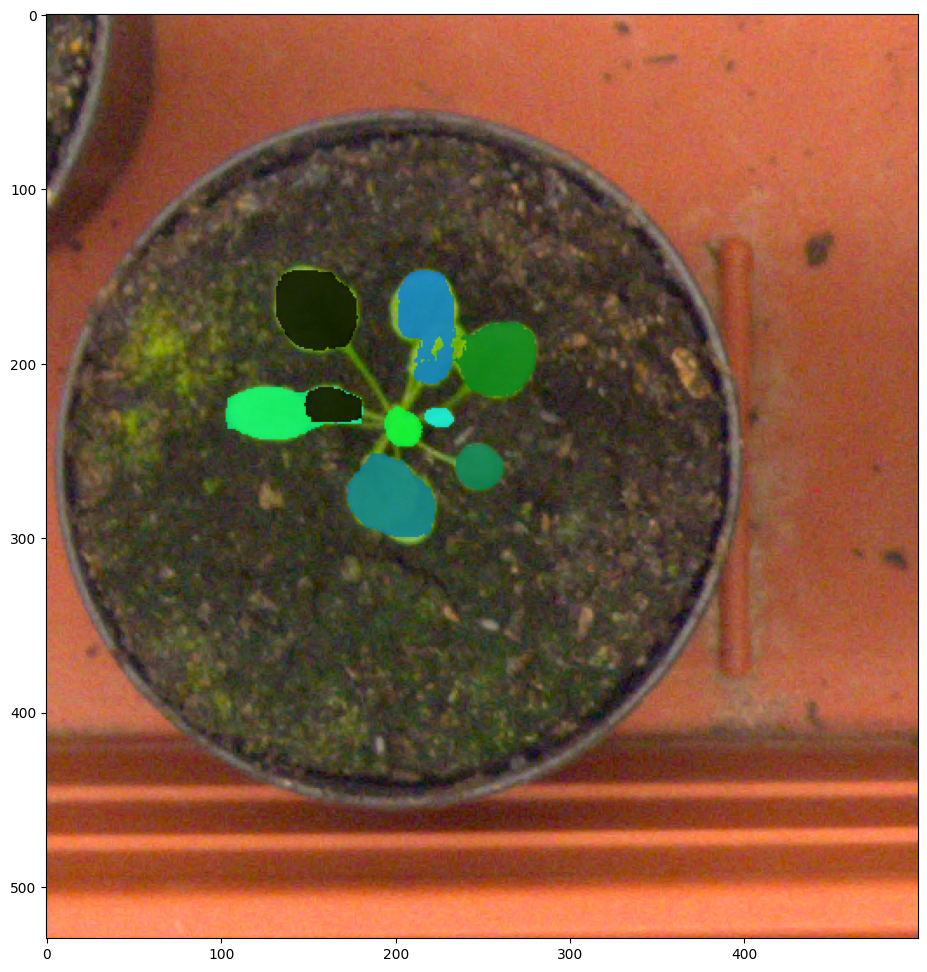

In [18]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("../data/A1/plant002_rgb.png", ImageReadMode.RGB)
labels = read_image("../data/A1/plant002_label.png")
labels_unique = torch.unique(labels)
print(labels_unique.shape)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

masks = (pred["masks"] > 0.7).squeeze(1)
print(masks.shape)
image = draw_segmentation_masks(image, masks[:labels_unique.shape[0]-3])


plt.figure(figsize=(12, 12))
plt.imshow(image.permute(1, 2, 0))